Enter tickers separated by commas (e.g., AAPL,MSFT,SPY):  AAPL,MSFT,JPM


Valid tickers being used: AAPL, MSFT, JPM


Enter 3 weights separated by commas (sum must be 1), or press Enter for equal weights:  
Enter confidence level (e.g., 0.95 for 95%). Press Enter for default (0.95):  



Historical 1-day 95% VaR: -2.84%
Monte Carlo 1-day 95% VaR (10,000 sims): -3.11%
Parametric 1-day 95% VaR: -3.15%


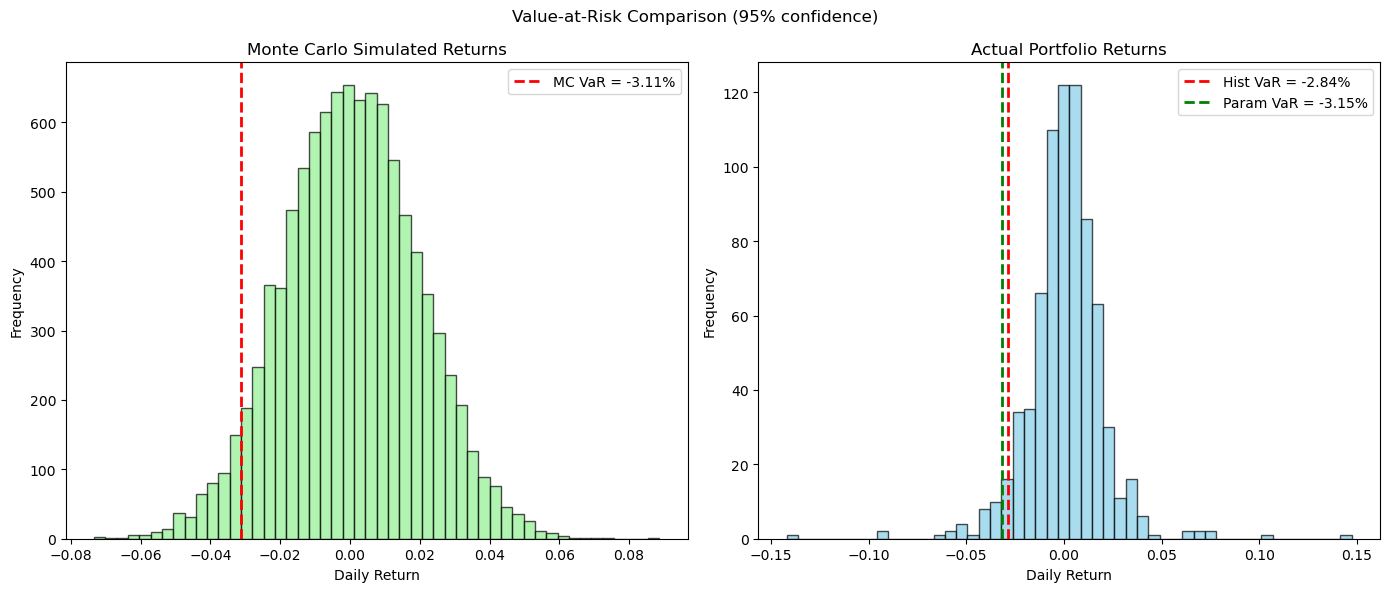

In [2]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

def returns_data(tickers, start="2020-01-01", end="2023-01-01"):
    """
    Download adjusted close prices for given tickers and calculate daily returns.
    Skips invalid tickers and warns the user.
    
    Parameters:
        tickers (list of str): List of ticker symbols.
        start (str): Start date in 'YYYY-MM-DD' format.
        end (str): End date in 'YYYY-MM-DD' format.
        
    Returns:
        pd.DataFrame: Daily returns of valid tickers.
    """
    data_dict = {}
    failed = []

    # Download each ticker individually and store valid data
    for t in tickers:
        try:
            data = yf.download(t, start=start, end=end, auto_adjust=True, progress=False)
            if data.empty or "Close" not in data:
                failed.append(t)
            else:
                data_dict[t] = data["Close"]
        except:
            failed.append(t)

    if not data_dict:
        raise ValueError("No valid tickers could be downloaded. Check your tickers or date range.")

    if failed:
        print(f"Warning: The following tickers failed and will be skipped: {', '.join(failed)}")

    # Combine all valid ticker series into a DataFrame
    close = pd.concat(data_dict.values(), axis=1)
    close.columns = list(data_dict.keys())

    returns = close.pct_change(fill_method=None).dropna()

    if returns.empty:
        raise ValueError("No returns could be computed. Try a different date range.")

    return returns

def portfolio_returns(returns, weights=None):
    """
    Calculate portfolio daily returns.
    
    Parameters:
        returns (pd.DataFrame): Daily returns of each asset.
        weights (list or np.array): Portfolio weights. Defaults to equal weights.
    
    Returns:
        pd.Series: Portfolio daily returns.
    """
    n_assets = returns.shape[1]
    if weights is None:
        weights = np.repeat(1 / n_assets, n_assets)
    else:
        weights = np.array(weights)
        if len(weights) != n_assets:
            raise ValueError(f"Number of weights ({len(weights)}) does not match number of valid tickers ({n_assets})")
        if not np.isclose(weights.sum(), 1):
            raise ValueError("Weights must sum to 1.")
    return returns.dot(weights)

def historical_var(portfolio_ret, confidence=0.95):
    """
    Compute Historical (empirical) Value at Risk (VaR).
    """
    percentile = 100 * (1 - confidence)
    return np.percentile(portfolio_ret, percentile)

def monte_carlo_var(portfolio_ret, confidence=0.95, n_sim=10000):
    """
    Compute Monte Carlo simulated VaR.
    """
    mu = portfolio_ret.mean()
    sigma = portfolio_ret.std()
    if sigma == 0:
        raise ValueError("Standard deviation is zero. Cannot run Monte Carlo simulation.")
    simulated = np.random.normal(mu, sigma, n_sim)
    percentile = 100 * (1 - confidence)
    var_mc = np.percentile(simulated, percentile)
    return var_mc, simulated

def parametric_var(portfolio_ret, confidence=0.95):
    """
    Compute Parametric (Normal model) VaR.
    """
    mu = portfolio_ret.mean()
    sigma = portfolio_ret.std()
    z = norm.ppf(1 - confidence)
    return mu + z * sigma

def plot_var_comparison(portfolio_ret, simulated_returns, hist_var, mc_var, param_var, confidence_level):
    """
    Plot Monte Carlo simulated returns and actual portfolio returns with VaR lines.
    """
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    # Monte Carlo histogram
    axs[0].hist(simulated_returns, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axs[0].axvline(mc_var, color='red', linestyle='--', linewidth=2, label=f'MC VaR = {mc_var:.2%}')
    axs[0].set_title("Monte Carlo Simulated Returns")
    axs[0].set_xlabel("Daily Return")
    axs[0].set_ylabel("Frequency")
    axs[0].legend()

    # Historical + Parametric histogram
    axs[1].hist(portfolio_ret, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axs[1].axvline(hist_var, color='red', linestyle='--', linewidth=2, label=f'Hist VaR = {hist_var:.2%}')
    axs[1].axvline(param_var, color='green', linestyle='--', linewidth=2, label=f'Param VaR = {param_var:.2%}')
    axs[1].set_title("Actual Portfolio Returns")
    axs[1].set_xlabel("Daily Return")
    axs[1].set_ylabel("Frequency")
    axs[1].legend()

    plt.suptitle(f"Value-at-Risk Comparison ({int(confidence_level*100)}% confidence)")
    plt.tight_layout()
    plt.show()

def main():
    try:
        # User input for tickers
        tickers_input = input("Enter tickers separated by commas (e.g., AAPL,MSFT,SPY): ")
        user_tickers = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]
        if not user_tickers:
            raise ValueError("No tickers provided.")

        # Download returns
        returns = returns_data(user_tickers)

        # List of valid tickers
        valid_tickers = returns.columns.tolist()
        n_assets = len(valid_tickers)
        print(f"Valid tickers being used: {', '.join(valid_tickers)}")

        # User input for weights
        user_input = input(f"Enter {n_assets} weights separated by commas (sum must be 1), or press Enter for equal weights: ")
        if user_input.strip() == "":
            weights = None
        else:
            weights = [float(w.strip()) for w in user_input.split(",")]

        # User input for confidence level
        conf_input = input("Enter confidence level (e.g., 0.95 for 95%). Press Enter for default (0.95): ")
        confidence = float(conf_input) if conf_input.strip() != "" else 0.95
        if not (0 < confidence < 1):
            raise ValueError("Confidence level must be between 0 and 1.")

        # Portfolio returns
        port_ret = portfolio_returns(returns, weights)

        # Compute VaR
        hist_var = historical_var(port_ret, confidence)
        mc_var, simulated = monte_carlo_var(port_ret, confidence)
        param_var = parametric_var(port_ret, confidence)

        # Print results as percentages
        print(f"\nHistorical 1-day {int(confidence*100)}% VaR: {hist_var:.2%}")
        print(f"Monte Carlo 1-day {int(confidence*100)}% VaR (10,000 sims): {mc_var:.2%}")
        print(f"Parametric 1-day {int(confidence*100)}% VaR: {param_var:.2%}")

        # Plot VaR comparison
        plot_var_comparison(port_ret, simulated, hist_var, mc_var, param_var, confidence)

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()
